In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pypsa
import pandas as pd
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch

In [3]:
%matplotlib inline
plt.style.use("bmh")

## Stats

In [4]:
def check_curtailment(n):
    possible = (n.generators_t.p_max_pu * n.generators.p_nom_opt).filter(regex="(ror|solar|wind)", axis=1).sum().sum()
    generated = n.generators_t.p.filter(regex="(ror|solar|wind)", axis=1).sum().sum()
    return (1 - generated / possible) * 100 # %

In [5]:
def check_energy_balance(n):
    gen = n.generators_t.p.multiply(n.snapshot_weightings, axis=0).sum().sum()
    sto = n.storage_units_t.p.multiply(n.snapshot_weightings, axis=0).sum().sum()
    load = n.loads_t.p_set.multiply(n.snapshot_weightings, axis=0).sum().sum()
    loss = n.lines_t.loss.multiply(n.snapshot_weightings, axis=0).sum().sum()
    loss_share = loss / (gen+sto) * 100 # %
    balance = (gen + sto - loss - load) / 1e6 # TWh
    return balance, loss_share

In [6]:
def check_energy_transmitted(n, branch="lines"):
    branches_t = getattr(n, branch+"_t")
    branches = getattr(n, branch)
    return branches_t.p0.abs().multiply(n.snapshot_weightings, axis=0).multiply(branches.length).sum().sum() / 1e6 # TWhkm

In [7]:
def check_energy_generated(n):
    n.generators["energy"] = n.generators_t.p.multiply(n.snapshot_weightings, axis=0).sum()
    generated = n.generators.groupby("carrier").energy.sum() / 1e6 # TWh
    generated["inflow"] = n.storage_units_t.inflow.multiply(n.snapshot_weightings, axis=0).sum().sum() / 1e6 # TWh
    return generated

In [8]:
def check_costs(n):
    
    abs_c = aggregate_costs(n).sum() # bn EUR/a
    rel_c = abs_c / n.loads_t.p_set.multiply(n.snapshot_weightings, axis=0).sum().sum() * 1e9 # EUR/MWh
    
    return abs_c, rel_c

In [9]:
def check_capacities(n):
    
    return pd.concat([
        n.generators.groupby("carrier").p_nom_opt.sum() / 1e3, # GW
        n.storage_units.groupby("carrier").p_nom_opt.sum() / 1e3, # GW
        pd.Series({"links": n.links.eval("length * (p_nom_opt - p_nom) / 1e6").sum()}), # TWkm
        pd.Series({"lines": n.lines.eval("length * (s_nom_opt - s_nom) / 1e6").sum()}) # TWkm
    ])

In [10]:
def check_flow_errors(n, n_pf):
    
    pf = n_pf.lines_t.p0.stack()

    lopf = n.lines_t.p0.stack()

    mse = pf.sub(lopf).pow(2).mean()
    rmse = mse ** 0.5
    mape = pf.sub(lopf).div(pf).abs().mean()
    mae = pf.sub(lopf).abs().mean()
    corr = pf.corr(lopf)
    r2 = corr ** 2
    return (mse, rmse, mae, mape, corr, r2)

## Multiuse Functions

In [471]:
def plot_hist_helper(ax, x, y, xlim, ylim, style='hexbin', vmin=0, vmax=400):
    
    if style == "scatter":
        ax.scatter(x, y, alpha=0.2, marker=".")
    elif style == "hexbin":
        scope = xlim + ylim
        plt.hexbin(x, y, gridsize=100, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax, extent=xlim + ylim)
    elif style == "hist2d":
        scope = np.array([xlim, ylim])
        plt.hist2d(x, y, bins=100, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax, linewidths=0, range=scope)

In [472]:
def reference(ax, low, high, res=100, lw=1, c="k", f=lambda x: x):
    x = np.linspace(low,high,res)
    ax.plot(x,f(x),c='k',linewidth=lw);

## Single LOPF: Maps

In [473]:
def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()
    def axes2pt():
        return np.diff(ax.transData.transform([(0,0), (1,1)]), axis=0)[0] * (300./fig.dpi)

    ellipses = []
    if not dont_resize_actively:
        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses: e.width, e.height = 2. * radius * dist
        fig.canvas.mpl_connect('resize_event', update_width_height)
        ax.callbacks.connect('xlim_changed', update_width_height)
        ax.callbacks.connect('ylim_changed', update_width_height)

    def legend_circle_handler(legend, orig_handle, xdescent, ydescent,
                              width, height, fontsize):
        w, h = 2. * orig_handle.get_radius() * axes2pt()
        e = Ellipse(xy=(0.5*width-0.5*xdescent, 0.5*height-0.5*ydescent), width=w, height=w)
        ellipses.append((e, orig_handle.get_radius()))
        return e
    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}

In [474]:
def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0,0), radius=(s/scale)**0.5, **kw) for s in sizes]

In [475]:
def add_legend(ax, bus_factor, branch_factor):
    
    handles = []
    labels = []
    for s in (2,5,10):
        handles.append(plt.Line2D([0],[0],color='rosybrown',
                                  linewidth=s*1e3/branch_factor))
        labels.append(f"{s} GW")
    l1 = ax.legend(handles, labels,
                   loc="upper left", bbox_to_anchor=(0,0),
                   frameon=False,
                   labelspacing=0.8, handletextpad=1.5,
                   title='HVAC Line Capacity')
    ax.add_artist(l1)
    
    handles = []
    labels = []
    for s in (2,5,10):
        handles.append(plt.Line2D([0],[0],color='darkseagreen',
                                  linewidth=s*1e3/branch_factor))
        labels.append(f"{s} GW")
    l2 = ax.legend(handles, labels,
                   loc="upper left", bbox_to_anchor=(0.2, -0.),
                   frameon=False,
                   labelspacing=0.8, handletextpad=1.5,
                   title='HVDC Link Capacity')
    ax.add_artist(l2)
    
    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    for name, carrier in n.carriers.iterrows():
        handles.append(plt.Line2D([0], [0], color=carrier.color, marker='o', markersize=8, linewidth=0))
        labels.append(carrier.nice_name)
    l3 = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.58, -0.), # bbox_to_anchor=(0.72, -0.05),
                   handletextpad=0., columnspacing=0.5, ncol=2, title='Technology', frameon=False)
    ax.add_artist(l3)
                      
    circles = [1000, 100]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{int(s/1e2)} GW" for s in circles]
    l4 = ax.legend(handles, labels,
                   loc="upper left", bbox_to_anchor=(0.82, 0.),
                   frameon=False, labelspacing=2.5,
                   title='Generation',
                   handler_map=make_handler_map_to_scale_circles_as_in(ax, True))
    ax.add_artist(l4)

In [476]:
def plot_network(n, fn='test.png'):
    
    bus_factor = 1e5
    branch_factor = 1e3

    fields = ["bus", "carrier", "p_nom_opt"]
    pie_components = pd.concat([n.generators.loc[n.generators.carrier!="load",fields], n.storage_units[fields]])
    bus_sizes = pie_components.groupby(["bus","carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df>thres, other=0.)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = clip(n.lines.s_nom_opt) / branch_factor

    fig, ax = plt.subplots(figsize=(11,11), subplot_kw={"projection":ccrs.PlateCarree()})

    n.plot(ax=ax, bus_sizes=bus_sizes, color_geomap=True, bus_alpha=0.7, line_widths=line_widths_opt, line_colors='#dddddd');

    n.plot(ax=ax, geomap=False, bus_sizes=0, line_widths=line_widths, link_widths=link_widths);

    add_legend(ax, bus_factor, branch_factor)

    plt.savefig(fn, bbox_inches='tight')

In [697]:
def plot_network_losses(n, fn="test.png"):
    
    lc = n.lines_t.loss.mean()
    lw = n.lines_t.p0.abs().mean() / 200

    fig, ax = plt.subplots(figsize=(7,7), subplot_kw={"projection":ccrs.PlateCarree()})
    
    n.plot(ax=ax, color_geomap=True, line_widths=lw, line_colors=lc, bus_sizes=5e-3, bus_colors="darkgray", bus_alpha=0.8, link_widths=0)

    plt.savefig(fn, bbox_inched="tight")

## Single LOPF: Plots

In [478]:
def plot_flow_vs_loss(n, norm="max", style="hist2d", title="", fn="test.png"):

    fig, ax = plt.subplots(figsize=(6,5))

    line_loading = (n.lines_t.p0 / n.lines[f"s_nom_{norm}"] / n.lines.s_max_pu).stack()
    max_loss = n.lines.r_pu_eff * (n.lines.s_max_pu * n.lines[f"s_nom_{norm}"]) ** 2
    relative_loss = (n.lines_t.loss / max_loss).stack()

    xlim = [-1,1]
    ylim = [0,1]

    plot_hist_helper(ax, line_loading, relative_loss, xlim, ylim, vmax=100, style=style)

    reference(ax, *xlim, f=lambda x: x ** 2)
    
    if style in ["hexbin", "hist2d"]:
        cb = plt.colorbar(ax=ax, shrink=0.95)
        cb.set_label('Count')

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    plt.ylabel("Rel. Losses (LOPF)")
    plt.xlabel("Rel. Line Flows (LOPF)")
    
    plt.title(title)
    plt.savefig(fn, dpi=400, bbox_inches='tight')

## Single (LOPF, PF): Plots

In [480]:
def plot_loss_comparison(n, n_pf, style="hist2d", title="", fn="test.png", norm="max"):

    fig, ax = plt.subplots(figsize=(6,5))

    max_loss = n.lines.r_pu_eff * (n.lines.s_max_pu * n.lines[f"s_nom_{norm}"]) ** 2

    pf_loss = ((n_pf.lines_t.p0 + n_pf.lines_t.p1) / max_loss).stack()
    lopf_loss = (n.lines_t.loss / max_loss).stack()
    
    xlim = ylim = [0,1]

    plot_hist_helper(ax, lopf_loss, pf_loss, xlim, ylim, style=style, vmax=100)

    reference(ax, *xlim, f=lambda x: x)
    
    if style in ["hexbin", "hist2d"]:
        cb = plt.colorbar(ax=ax, shrink=0.95)
        cb.set_label('Count')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    plt.xlabel("Rel. Losses (LOPF)")
    plt.ylabel("Rel. Losses (PF)")
    
    plt.title(title)
    plt.savefig(fn, dpi=400, bbox_inches='tight')

In [481]:
def plot_flow_comparison(n, n_pf, style="hist2d", title="", fn="test.png"):
    
    pf = (n_pf.lines_t.p0 / n.lines.s_nom_opt).stack()
    lopf = (n.lines_t.p0 / n.lines.s_nom_opt).stack()

    fig, ax = plt.subplots(figsize=(6,5))

    xlim = [-1,1]
    ylim = [-.8,.8]

    plot_hist_helper(ax, pf, lopf, xlim, ylim, style=style, vmax=500)

    if style in ["hexbin", "hist2d"]:
        cb = plt.colorbar(ax=ax, shrink=0.75)
        cb.set_label('Count')

    reference(ax, -1,1)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_yticks(np.arange(ylim[0], ylim[1]+0.2, 0.2))
    ax.set_xticks(np.arange(xlim[0], xlim[1]+0.2, 0.2))
    plt.xticks(rotation=90)
    
    ax.set_aspect(1)
    
    plt.xlabel("Rel. Line Flows (PF)")
    plt.ylabel("Rel. Line Flows (LOPF)")
    
    plt.title(title)
    plt.savefig(fn, dpi=400, bbox_inches='tight')

## Multiple LOPF: Bar Charts

In [24]:
def assign_carriers(n):
    
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    
    if "carrier" not in n.lines:
        n.lines["carrier"] = "AC"

    if n.links.empty: n.links["carrier"] = pd.Series(dtype=str)
        
    config = {
        "AC": {"color": "rosybrown", 'nice_name': "HVAC Line"},
        "DC": {"color": "darkseagreen", 'nice_name': "HVDC Link"}
    }
        
    for c in ["AC", "DC"]:
        if c in n.carriers.index: continue
        n.carriers = n.carriers.append(pd.Series(config[c], name=c))

In [25]:
def aggregate_costs(n, existing_only=False, by_carrier=True):

    components = dict(Link=("p_nom", "p0"),
                      Generator=("p_nom", "p"),
                      StorageUnit=("p_nom", "p"),
                      Store=("e_nom", "p"),
                      Line=("s_nom", None))

    costs = {}
    for c in n.iterate_components(components.keys()):
        p_nom, p_attr = components[c.name]
        if c.df.empty: continue
        if not existing_only: p_nom += "_opt"
        costs[(c.list_name, 'capital')] = (c.df[p_nom] * c.df.capital_cost).groupby(c.df.carrier).sum()
        if p_attr is not None:
            p = c.pnl[p_attr].multiply(n.snapshot_weightings, axis=0).sum()
            if c.name == 'StorageUnit':
                p = p.loc[p > 0]
            costs[(c.list_name, 'marginal')] = (p*c.df.marginal_cost).groupby(c.df.carrier).sum()
    costs = pd.concat(costs) / 1e9 # bn EUR/a
    
    if by_carrier:
        costs = costs.groupby(level=2).sum()

    return costs

In [701]:
def plot_cost_bar(networks, model_names, fn="test.png"):
    
    for n in networks.values():
        assign_carriers(n)

    costs = pd.concat({k: aggregate_costs(v) for k,v in networks.items()}, axis=1).T

    if "load" in costs.columns:
        costs.drop(columns=["load"], inplace=True)

    colors = n.carriers.color.reindex(index=costs.columns).values

    costs.rename(columns=n.carriers.nice_name, index=model_names, inplace=True)
    costs.columns.name = "Technology"

    fig, ax = plt.subplots(figsize=(6,4))

    costs.plot.bar(ax=ax, stacked=True, color=colors)

    plt.legend(ncol=1, bbox_to_anchor=(1,1.02))

    plt.xticks(rotation=0)
    plt.ylabel("Total System Costs [bn Euro / a]")
    
    plt.savefig(fn, bbox_inches="tight")

## Multiple LOPF: Memory and Time

## Application

In [4]:
flow_models = ["transport", "lossless-0", "lossless-3", "lossy-5", "lossy-8"]

In [5]:
networks = {fm: pypsa.Network(f"results/networks/elec_s_100_ec_lcopt_2H_M{fm}.nc") for fm in flow_models}

Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_2H_Mtransport.nc has buses, carriers, generators, lines, links, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_2H_Mlossless-0.nc has buses, carriers, generators, lines, links, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_2H_Mlossless-3.nc has buses, carriers, generators, lines, links, loads, storage_units
Importin

In [6]:
n = networks["lossless-3"]

(-1000, 50)

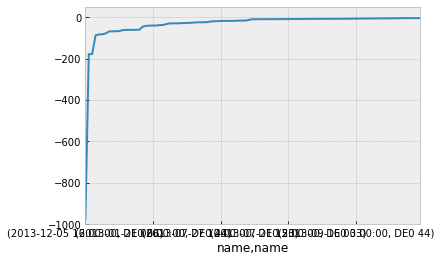

In [34]:
n.buses_t.marginal_price.stack().sort_values().iloc[:100].plot()
plt.ylim([-1000,50])

In [10]:
networks_pf = {fm: pypsa.Network(f"results/pf/elec_s_100_ec_lcopt_2H_M{fm}_Sdistributed.nc") for fm in flow_models}

Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_2H_Mtransport_Sdistributed.nc has buses, carriers, generators, lines, links, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_2H_Mlossless-0_Sdistributed.nc has buses, carriers, generators, lines, links, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_2H_Mlossless-3_Sdistributed.nc has buses, carriers, generators, line

In [11]:
npf = networks_pf["lossless-3"]

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


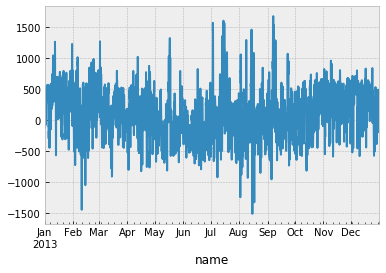

In [20]:
npf.lines_t.p0.iloc[:,1].plot()

In [27]:
for n in networks.values():
    assign_carriers(n)

In [15]:
model_names = {
    "transport": "Transport",
    "lossless-0": "Lossless",
    "lossless-3": "Iterative\nLossless",
    "lossy-5": "Iterative\nLossy\n(5 Tangents)",
    "lossy-8": "Iterative\nLossy\n(8 Tangents)"
}

In [18]:
d = "summary/"

In [19]:
csvargs = {"float_format": "%.3f"}

In [20]:
pd.DataFrame({k: check_flow_errors(networks[k], networks_pf[k]) for k in networks.keys()}, index=["mse", "rmse", "mae", "mape", "corr", "r2"]).to_csv(f"{d}flow_errors.csv", **csvargs)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [21]:
pd.DataFrame({k: check_capacities(v) for k, v in networks.items()}).to_csv(f"{d}capacity.csv", **csvargs)

In [22]:
pd.DataFrame({k: check_energy_generated(v) for k, v in networks.items()}).to_csv(f"{d}energy.csv", **csvargs)

In [28]:
pd.DataFrame({k: [check_curtailment(v), check_energy_transmitted(v), *check_costs(v)] for k, v in networks.items()}, index=["curtailment", "energy-transmitted", "absolute-tsc", "relative-tsc"]).to_csv(f"{d}misc.csv", **csvargs)

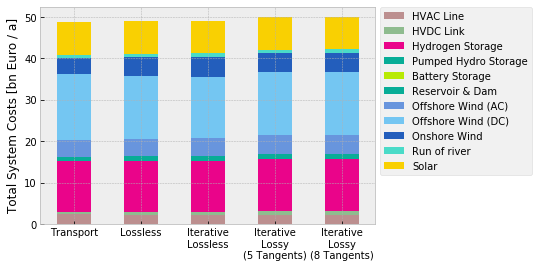

In [727]:
plot_cost_bar(networks, model_names, fn=f"{d}cost-bar.pdf")

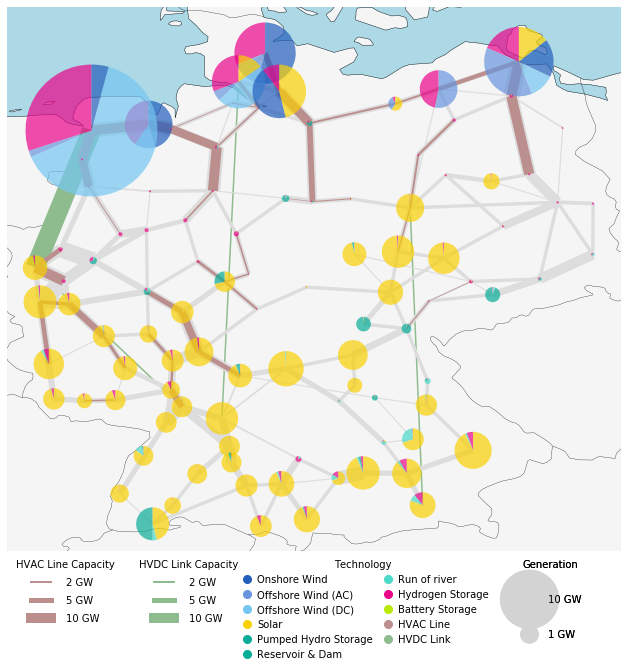

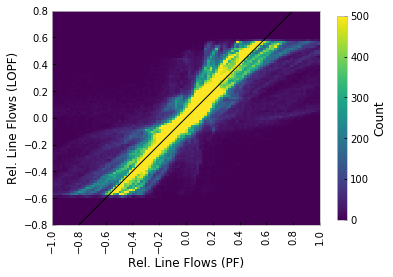

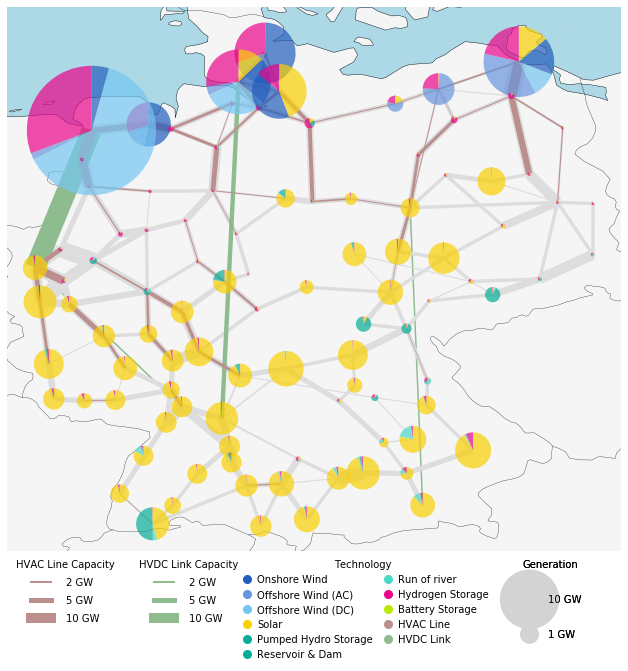

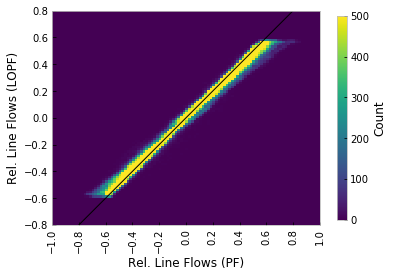

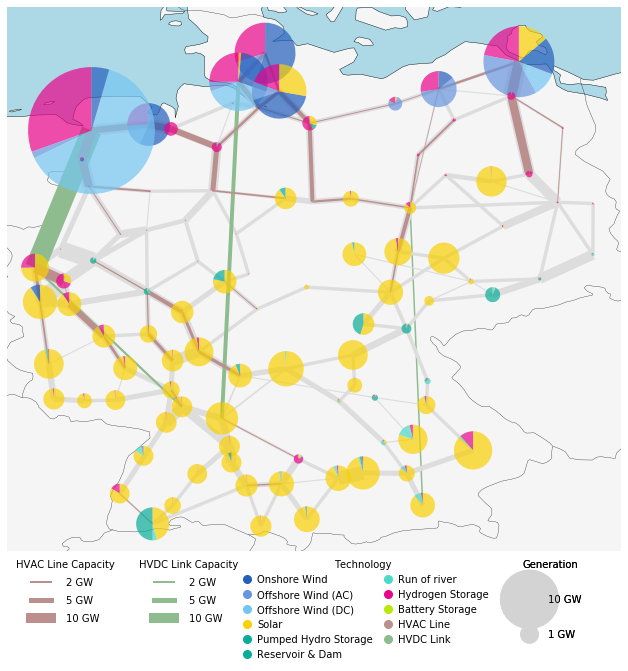

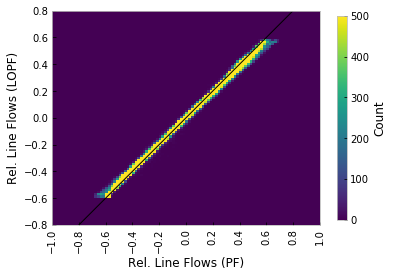

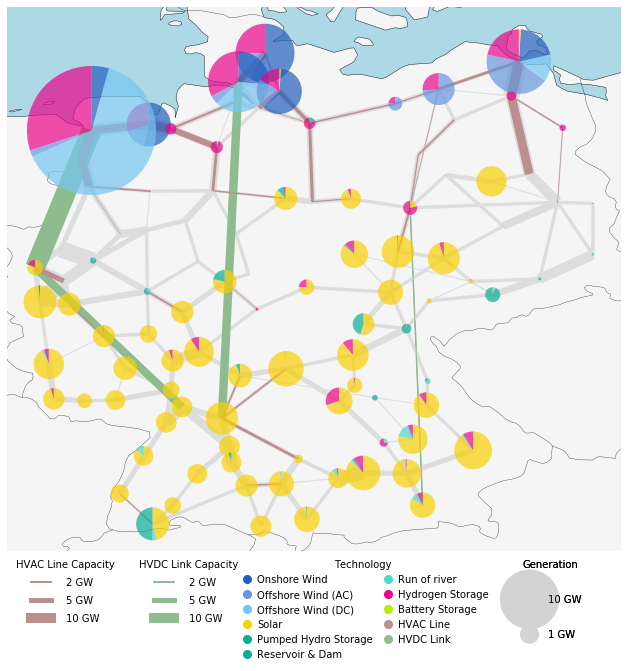

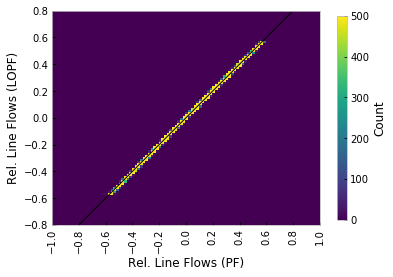

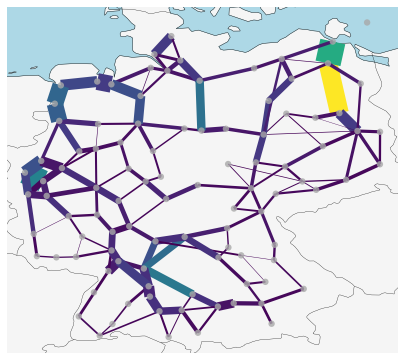

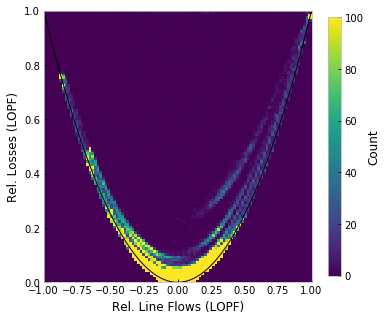

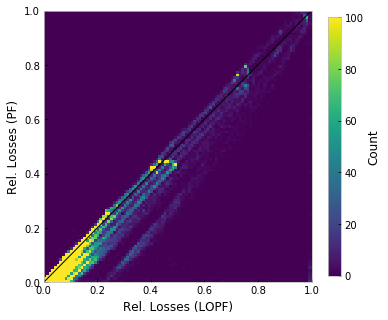

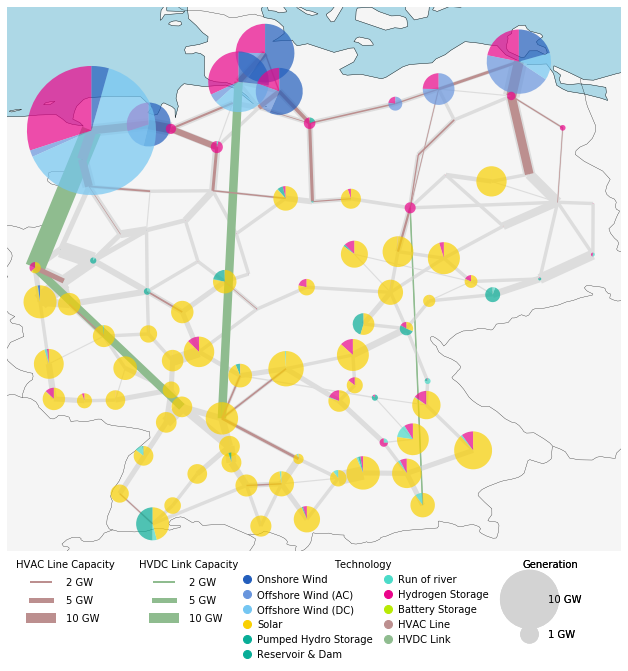

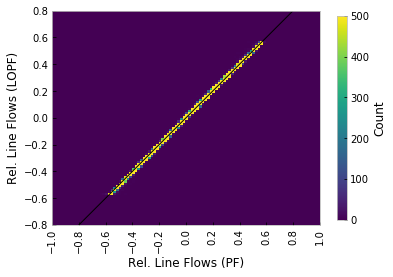

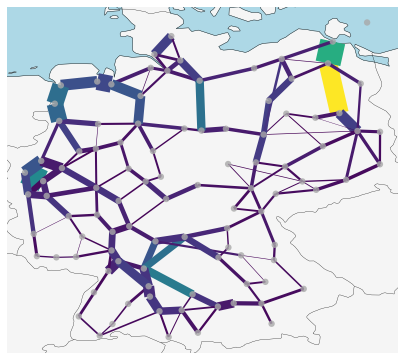

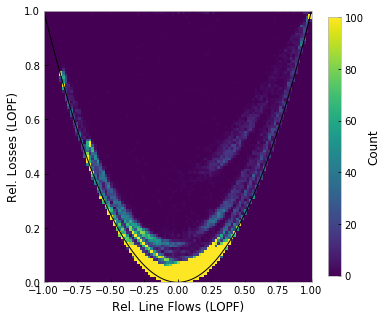

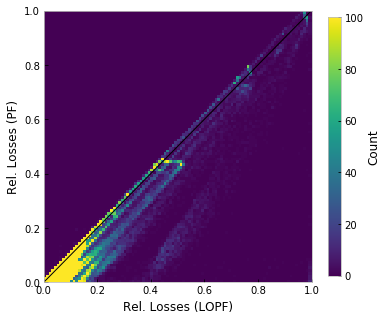

In [728]:
for name in networks.keys():
    
    n = networks[name]
    n_pf = networks_pf[name]
    
    plot_network(n, fn=f"{d}network-{name}.pdf")
    
    plot_flow_comparison(n, n_pf, fn=f"{d}flow-comparison-{name}.pdf")
    
    if "lossy" in name:
        plot_network_losses(n, fn = f"{d}network-losses-{name}.pdf")
        plot_flow_vs_loss(n, fn=f"{d}flow-vs-loss-{name}.pdf")
        plot_loss_comparison(n, n_pf, fn=f"{d}loss-comparison-{name}.pdf")